<a id="id_0"></a>
# Build Model
## Context
**Project Name:** Predict Netflix titles that Mum will watch          
**Written by:** Claudia Wallis         
**Created:** 27/02/2022           
**Last modifed:** 27/02/20212           

## Objective
**Build model to identify Netflix titles that Mum will watch**           

## Input Data 
1. label_file_mum.pkl from 1.prepare_label_file.ipynb


## Table of Contents
1. [Set Up](#id_1)
    - 1a. Import packages
    - 1b. Update variables
2. [Load Label File](#id_2)
    - 2a. Load data
    - 2b. Remove any string columns
    - 2c. Checks
3. [Prepare Label File for Modeling](#id_3)
    - 3a. Downsample
    - 3b. Split into train & test set
    - 3c. Checks
4. [Choose Best Model](#id_4)
    - 4a. Evaluate multiple algorithms
    - 4b. Tune Model
5. [Build Model & Evaluate on Validation](#id_5)
    - 5a. Build Model
    - 5b. Evaluate Model on validation set
    - 5c. Save Model
6. [Feature Importance](#id_6)

<a id="id_1"></a>
## 1. Set Up
#### 1a) Import packages

In [1]:
# base packages
import pandas as pd
import numpy as np

# etc
import time
import pickle
import os
import random
from random import sample
import math

# visualisation and data wrangling
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf

# modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, auc, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb 
from collections import Counter
from imblearn.over_sampling import SMOTE
import shap

# pipeline functions
os.chdir('C:\\Users\\claud\\Documents\\code\\')
import pipeline; import importlib; importlib.reload(pipeline)
from pipeline.fns import data_summary, hex_rgb, down_sample

# python related
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#### 1b) Update Variables

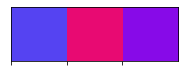

In [2]:
# update paths
path = 'C:\\Users\\claud\\Documents\\data\\'

# set seed 
seed = 24
random.seed(seed)

# set key colours
palette = ['#5543F2', '#E80A72', '#870AE8']
sns.set_palette(palette)
sns.palplot(sns.color_palette())
rgb_palette = hex_rgb(palette)

# plotting settings
cf.go_offline(connected = True)
init_notebook_mode(connected = True)
cf.set_config_file(world_readable = False, theme = 'pearl')
sns.set_style('dark')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',None)
pd.set_option('float_format', '{:f}'.format)

<a id="id_2"></a>
## 2. Load Data
#### 2a) Load data

In [3]:
label_file = pd.read_pickle(path + 'output_data//label_file_mum.pkl')

#### 2b) Remove any string columns

In [4]:
label_file.drop(['Title', 'Series or Movie_Series'], axis = 1, inplace = True)

#### 2c) Checks

In [5]:
print('Label File shape = ' + str(label_file.shape))
print('Label File outcome rate = ' +
      str(round(label_file[label_file['Label'] == 1].shape[0]/label_file.shape[0] * 100, 3)) +
      '%')
display(data_summary(label_file, id_col = 'Title id', gb_col = 'Label'))
display(label_file.head())
display(label_file.describe())
display(label_file.dtypes)

Label File shape = (3603, 109)
Label File outcome rate = 6.106%


,Label,row_count,unique_id_count
0,0,3383,3383
1,1,220,220


,Title id,IMDb Score,Rotten Tomatoes Score,Hidden Gem Score,Metacritic Score,Awards Received,Awards Nominated For,IMDb Votes,Label,Series or Movie_Movie,Runtime_1-2 hour,Runtime_30-60 mins,Runtime_< 30 minutes,Runtime_> 2 hrs,Grouped Rating_adult,Grouped Rating_child,Grouped Rating_teen,Grouped Rating_unrated,Drama_f,Comedy_f,Action_f,Thriller_f,Romance_f,Crime_f,Documentary_f,Adventure_f,Fantasy_f,Animation_f,Family_f,Mystery_f,Sci-Fi_f,Horror_f,Biography_f,History_f,Music_f,Sport_f,Short_f,War_f,Musical_f,Reality-TV_f,Cathy Garcia-Molina_f,Hayao Miyazaki_f,Jay Karas_f,Adam Sandler_f,Shah Rukh Khan_f,Priyanka Chopra_f,Mark Wahlberg_f,Liam Neeson_f,Eric Idle_f,John Cleese_f,Kevin James_f,Akshay Kumar_f,Ashleigh Ball_f,Nawazuddin Siddiqui_f,Terry Gilliam_f,Paresh Rawal_f,Russell Crowe_f,John Abraham_f,Summary Sentiment Score,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,PC 41,PC 42,PC 43,PC 44,PC 45,PC 46,PC 47,PC 48,PC 49,PC 50
0,0,6.600000,75.000000,3.500000,67.000000,1.000000,7.000000,13379.000000,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.100000,-0.716252,-0.314516,1.282396,0.287570,-0.633176,0.000586,-0.131588,-0.976245,-0.908923,-2.867811,-0.073949,-0.007425,0.191187,0.420787,-0.721545,-0.784760,-0.419608,-0.080717,0.790921,-0.079877,-0.013646,-0.042053,0.187084,0.225885,0.229385,0.063706,-0.834338,-0.777262,0.713264,0.883938,0.211103,-0.345172,0.883315,0.798204,-0.952768,-0.212655,0.315574,0.660882,0.763853,0.894385,-0.403871,0.218845,-0.620911,0.485023,-0.536382,0.566438,0.014420,0.396327,-1.039109,-0.589160
1,395,7.900000,67.702448,8.800000,59.729337,0.000000,0.000000,316.000000,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.162500,-1.093729,1.876351,0.527830,1.027895,-0.458980,0.587847,-0.189319,1.232237,-0.369278,1.148953,0.430350,-0.030827,-0.509201,2.327305,-0.411575,-0.717657,0.172921,0.661164,-0.859795,-0.430926,-0.471244,0.751459,-0.803842,-0.190330,0.857827,-0.840330,-0.909267,-0.868657,-0.154038,0.761136,1.198571,-0.201682,0.863825,0.638635,0.578779,-0.435813,-0.788379,0.178034,-1.500645,1.142484,-0.066357,-1.244451,0.447519,-0.432686,-1.161908,-0.036712,-0.345830,0.214265,-0.816803,-0.599684
2,396,6.600000,73.000000,7.500000,59.729337,4.000000,5.000000,1961.000000,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,2.109617,1.455054,-0.371671,-0.292224,-0.229532,1.563698,-0.120433,0.685080,-0.000402,-1.112118,1.164731,0.941369,0.139441,-0.257562,-0.663435,1.113153,-0.978819,0.203381,0.268712,-0.121058,0.149481,-1.570890,0.052486,-1.604925,-0.134360,0.574798,-0.670841,-0.904594,-0.704543,0.965110,0.098038,0.167387,0.100620,-0.364152,0.055019,-0.802061,-0.030563,0.192560,0.039807,-0.017621,1.119730,0.785456,0.401270,-0.841902,0.176716,-1.339089,-0.036599,-0.523341,-0.344866,0.190475
3,1,6.500000,44.000000,2.600000,48.000000,4.000000,12.000000,169614.000000,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.100000,-0.338825,1.181432,-0.092740,-1.274435,-1.341645,-0.626623,-1.273450,-0.223152,-0.470637,-0.741067,-0.344546,-0.161939,0.057589,-0.469794,-0.599930,-0.890802,0.370752,-0.355217,0.884080,-0.609705,0.246513,0.096614,0.255384,0.348060,-0.308350,-1.571420,0.123098,-0.456696,-0.120299,0.690545,-0.627425,-0.498030,-0.587984,0.124077,0.117290,-0.041087,0.226655,-0.536003,0.492933,-0.079123,0.350247,0.317667,0.013562,0.499972,-0.352400,0.418387,0.194268,0.097017,0.346538,-0.110097
4,2,8.000000,67.702448,9.000000,59.729337,0.000000,0.000000,40.000000,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,-1.294750,1.513075,-1.318381,0.378099,1.011087,-0.557

,Title id,IMDb Score,Rotten Tomatoes Score,Hidden Gem Score,Metacritic Score,Awards Received,Awards Nominated For,IMDb Votes,Label,Series or Movie_Movie,Runtime_1-2 hour,Runtime_30-60 mins,Runtime_< 30 minutes,Runtime_> 2 hrs,Grouped Rating_adult,Grouped Rating_child,Grouped Rating_teen,Grouped Rating_unrated,Drama_f,Comedy_f,Action_f,Thriller_f,Romance_f,Crime_f,Documentary_f,Adventure_f,Fantasy_f,Animation_f,Family_f,Mystery_f,Sci-Fi_f,Horror_f,Biography_f,History_f,Music_f,Sport_f,Short_f,War_f,Musical_f,Reality-TV_f,Cathy Garcia-Molina_f,Hayao Miyazaki_f,Jay Karas_f,Adam Sandler_f,Shah Rukh Khan_f,Priyanka Chopra_f,Mark Wahlberg_f,Liam Neeson_f,Eric Idle_f,John Cleese_f,Kevin James_f,Akshay Kumar_f,Ashleigh Ball_f,Nawazuddin Siddiqui_f,Terry Gilliam_f,Paresh Rawal_f,Russell Crowe_f,John Abraham_f,Summary Sentiment Score,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,PC 41,PC 42,PC 43,PC 44,PC 45,PC 46,PC 47,PC 48,PC 49,PC 50
count,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000
mean,1808.533444,7.081240,67.702448,5.976904,59.729337,4.195115,9.037469,45405.933296,0.061060,0.625590,0.435193,0.023036,0.387732,0.154038,0.293089,0.052734,0.252290,0.401887,0.475715,0.362198,0.182348,0.179850,0.177352,0.155426,0.140161,0.119067,0.108798,0.104357,0.101304,0.085762,0.077713,0.055787,0.055509,0.044130,0.035248,0.028865,0.025812,0.021094,0.020816,0.018041,0.003331,0.003053,0.002775,0.006384,0.005551,0.003886,0.003608,0.003331,0.003331,0.003331,0.003331,0.003331,0.003053,0.003053,0.003053,0.002775,0.002775,0.002775,0.049719,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
std,1045.976242,0.874886,16.418941,2.362168,9.015154,12.766187,24.289732,122111.531540,0.239474,0.484037,0.495851,0.150040,0.487301,0.361036,0.455242,0.223533,0.434387,0.490347,0.499479,0.480702,0.386185,0.384116,0.382020,0.362361,0.347202,0.323913,0.311429,0.305766,0.301773,0.280051,0.267757,0.229541,0.229003,0.205412,0.184433,0.167450,0.158596,0.143716,0.142788,0.133116,0.057623,0.055177,0.052617,0.079653,0.074308,0.062222,0.059967,0.057623,0.057623,0.057623,0.057623,0.057623,0.055177,0.055177,0.055177,0.052617,0.052617,0.052617,0.2687

Title id                     int64
IMDb Score                 float64
Rotten Tomatoes Score      float64
Hidden Gem Score           float64
Metacritic Score           float64
Awards Received            float64
Awards Nominated For       float64
IMDb Votes                 float64
Label                        int64
Series or Movie_Movie        uint8
Runtime_1-2 hour             uint8
Runtime_30-60 mins           uint8
Runtime_< 30 minutes         uint8
Runtime_> 2 hrs              uint8
Grouped Rating_adult         uint8
Grouped Rating_child         uint8
Grouped Rating_teen          uint8
Grouped Rating_unrated       uint8
Drama_f                      int64
Comedy_f                     int64
Action_f                     int64
Thriller_f                   int64
Romance_f                    int64
Crime_f                      int64
Documentary_f                int64
Adventure_f                  int64
Fantasy_f                    int64
Animation_f                  int64
Family_f            

<a id="id_3"></a>
## 3. Prepare Label File for Modeling
#### 3a) Split into train & test set
Note: Outcome rate is ~6% and so we have a very imbalanced training set. We need to consider methods of handling the imbalance.

In [6]:
# rearrange order
cols = label_file.columns.to_list()
label_file = label_file[[cols[8]] + cols[:8] + cols[9:]]

# create training set to capture 80% of our data
df_train_0 = label_file[label_file['Label'] == 0].sample(frac = 0.8)
df_train_1 = label_file[label_file['Label'] == 1].sample(frac = 0.8)
df_train = df_train_0.append(df_train_1)

# create test set to capture remaining 20% of our data
train_ids = df_train['Title id'].to_list()
df_test = label_file[~label_file['Title id'].isin(train_ids)]

# Checks
print('Train outcome rate = ' +
      str(round(df_train[df_train['Label'] == 1].shape[0]/df_train.shape[0] * 100, 3)) +
      '%')
display(df_train.shape)
display(data_summary(df_train, id_col = 'Title id', gb_col = 'Label'))

print('Test outcome rate = ' +
      str(round(df_test[df_test['Label'] == 1].shape[0]/df_test.shape[0] * 100, 3)) +
      '%')
display(df_test.shape)
display(data_summary(df_test, id_col = 'Title id', gb_col = 'Label'))

Train outcome rate = 6.107%


(2882, 109)

,Label,row_count,unique_id_count
0,0,2706,2706
1,1,176,176


Test outcome rate = 6.103%


(721, 109)

,Label,row_count,unique_id_count
0,0,677,677
1,1,44,44


#### 3b) Save training & test set

In [7]:
df_train.to_pickle(path + 'output_data//train_mum.pkl')
df_test.to_pickle(path + 'output_data//test_mum.pkl')

#### 3c) Downsample training Set
By downsampling the training set we remove a degree of this imbalance, however, this comes at the cost of a significant reduction in data. By downsampling so that the majority class = 10 * minority class we are left with ~20% of the data, and our data is still imbalanced with outcome rate of 10%.

In [8]:
ds_train_df = down_sample(df_train, id_col = 'Title id', x = 9)
print('Train outcome rate = ' +
      str(round(ds_train_df[ds_train_df['Label'] == 1].shape[0]/ds_train_df.shape[0] * 100, 3)) +
      '%')
display(ds_train_df.shape)
display(data_summary(ds_train_df, id_col = 'Title id', gb_col = 'Label'))

Train outcome rate = 10.0%


(1760, 109)

,Label,row_count,unique_id_count
0,0,1584,1584
1,1,176,176


#### 3d) Upsample training set
By upsampling  we can preserve the volume of our majority class while increasing the outcome rate to 50%.

We upsample using Smote (Synthetic Minority Oversampling Technique)
The SMOTE algorithm can be broken down into four steps:  
  - i. Choose a minority class input vector
  - ii. Compute the k-nearest neighbors (for some pre-specified k)
  - iii. Add k new points somewhere between the chosen point and each of its neighbors.
  - iv. Repeat the steps until data is balanced

In [9]:
df_train = df_train.drop(['Title id'], axis = 1)
X = np.array(df_train.loc[:,  df_train.columns != 'Label'])
y = np.array(df_train.loc[:,  df_train.columns == 'Label']).reshape(-1, 1)

sm = SMOTE(random_state = seed)
X_train, y_train = sm.fit_resample(X, y.ravel())

#Convert x and y back to dataframe from the numpy array output of smote
X_df = pd.DataFrame(X_train, columns = df_train.columns.to_list()[1:])
y_df = pd.DataFrame(y_train, columns = ['Label'])
os_train_df = pd.merge(y_df, X_df, left_index=True, right_index=True)


# Create new title index column - however these indices won't correctly link back to the title names
# to do this we would need to ensure indices weren't suffled and merge on index but we don't need to link
# training set titles up at this point so it isn't necessary


print('Train outcome rate = ' +
      str(round(os_train_df[os_train_df['Label'] == 1].shape[0]/os_train_df.shape[0] * 100, 3)) +
      '%')
display(os_train_df.shape)
os_train_df.reset_index(inplace = True)
display(data_summary(os_train_df, id_col = 'index', gb_col = 'Label'))
os_train_df.drop('index', axis = 1, inplace = True)

Train outcome rate = 50.0%


(5412, 108)

,Label,row_count,unique_id_count
0,0,2706,2706
1,1,2706,2706


<a id="id_4"></a>
## 4. Choose Best Model
We will use the oversampled data from 3d. Ideally we should be adding weights to ensure the Model understands that the training data isn't representative of the true population. However for simplicity in this use case I haven't included weights.
#### 4a) Evaluate multiple algorithms

In [11]:
X = os_train_df.values[:, 1:]
Y = os_train_df.values[:, 0]
validation_size = 0.20
num_folds = 10
ncores = 20
scoring = 'neg_log_loss'
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = validation_size, random_state = seed)

print('Baseline Model Score = ' + str(-math.log(1/2)))

Baseline Model Score = 0.6931471805599453


Wall time: 0 ns
RF: 0.134202 (0.003729)
KNN: 2.240192 (0.405923)
GBM: 0.125484 (0.005855)
LR: 0.649334 (0.054199)
LDA: 0.421478 (0.027935)
CART: 2.210127 (0.208888)
NB: 0.803863 (0.113210)
XGB: 0.068573 (0.014971)


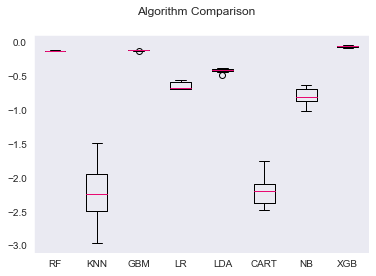

In [12]:
%time
models = []
models.append(('RF', RandomForestClassifier())) # Random Forest Classifier
models.append(('KNN', KNeighborsClassifier())) # K Nearest Neighbours
models.append(('GBM', GradientBoostingClassifier())) # Gradient Boosting Classifier
models.append(('LR', LogisticRegression())) # Logistic Regression
models.append(('LDA', LinearDiscriminantAnalysis())) # Linear Discriminant Analysis
models.append(('CART', DecisionTreeClassifier())) # Classification & Regression Trees
models.append(('NB', GaussianNB())) # Gaussian Naive Bayes
models.append(('XGB', XGBClassifier(eval_metric = 'mlogloss'))) # XGBoost Classifier

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring,
                                 n_jobs = ncores if name != 'XGB' else None)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, -cv_results.mean(), cv_results.std()))

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### 4b) Tune Model
[skip to next section](#id_5)          
**i. Minimun child weight:** defines the minimum sum of weights of all observations required in a child. Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
- Default = 1

Wall time: 0 ns
1: 0.000000 (train) 0.924863 (validation))
3: 0.000000 (train) 0.988648 (validation))
5: 0.000000 (train) 0.956758 (validation))
New parameter value for min_child_weight = 1


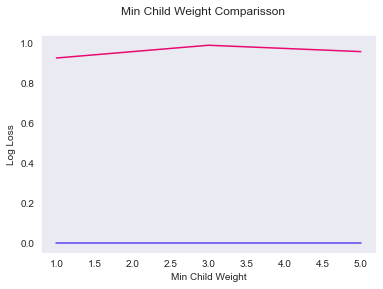

In [13]:
%time
min_child_weights = list(range(1,6,2))
train_results = []
valid_results = []
for min_child_weight in min_child_weights:
    model_tune = XGBClassifier(min_child_weight = min_child_weight, eval_metric = 'mlogloss',
                               seed = seed, n_jobs = None)
    model_tune.fit(X_train, Y_train)
    train_pred = model_tune.predict(X_train)
    ll_train = log_loss(Y_train, train_pred)
    train_results.append(ll_train)
    valid_pred = model_tune.predict(X_validation)
    ll_valid = log_loss(Y_validation, valid_pred)
    valid_results.append(ll_valid)
    print('%s: %f (train) %f (validation))' % (min_child_weight, ll_train, ll_valid))
    
    # identify best_min_child_weight
    if min_child_weight == min_child_weights[0]:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_min_child_weight = min_child_weight
    elif ll_valid < best_ll_valid:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_min_child_weight = min_child_weight
    elif ll_valid == best_ll_valid:
        if ll_train < best_ll_train:
            best_min_child_weight = min_child_weight
     
print('New parameter value for min_child_weight = ' + str(best_min_child_weight))   
fig = plt.figure()
fig.suptitle('Min Child Weight Comparisson')
line1 = plt.plot(min_child_weights, train_results, label = 'Train Log Loss')
line2 = plt.plot(min_child_weights, valid_results, label = 'Validation Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('Min Child Weight')
plt.show()

**ii. Max depth :** The maximum depth of a tree, same as GBM. Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
- Default = 6

Wall time: 0 ns
1: 1.515919 (train) 1.913521 (validation))
5: 0.000000 (train) 0.924863 (validation))
9: 0.000000 (train) 0.892971 (validation))
13: 0.000000 (train) 0.988647 (validation))
17: 0.000000 (train) 0.924863 (validation))
21: 0.000000 (train) 0.924863 (validation))
25: 0.000000 (train) 0.924863 (validation))
29: 0.000000 (train) 0.924863 (validation))

New parameter value for max_depth = 9


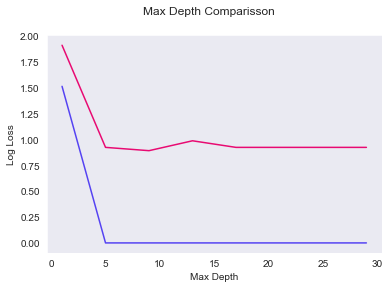

In [14]:
%time
max_depths = list(range(1, 32, 4))
train_results = []
valid_results = []
for max_depth in max_depths:
    model_tune = XGBClassifier(max_depth = max_depth, eval_metric = 'mlogloss', seed = seed, n_jobs = None,
                               min_child_weight = best_min_child_weight)
    model_tune.fit(X_train, Y_train)
    train_pred = model_tune.predict(X_train)
    ll_train = log_loss(Y_train, train_pred)
    train_results.append(ll_train)
    valid_pred = model_tune.predict(X_validation)
    ll_valid = log_loss(Y_validation, valid_pred)
    valid_results.append(ll_valid)
    print('%s: %f (train) %f (validation))' % (max_depth, ll_train, ll_valid))
    
    # identify best max_depth
    if max_depth == max_depths[0]:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_max_depth = max_depth
    elif ll_valid < best_ll_valid:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_max_depth = max_depth
    elif ll_valid == best_ll_valid:
        if ll_train < best_ll_train:
            best_max_depth = max_depth
     
    
print('\nNew parameter value for max_depth = ' + str(best_max_depth))   

fig = plt.figure()
fig.suptitle('Max Depth Comparisson')
line1 = plt.plot(max_depths, train_results, label = 'Train Log Loss')
line2 = plt.plot(max_depths, valid_results, label = 'Validation Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('Max Depth')
plt.show()

**iii. Subsample :** Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
- Default = 1

Wall time: 0 ns
0.6: 0.000000 (train) 0.733513 (validation))
0.7: 0.000000 (train) 0.733513 (validation))
0.8: 0.000000 (train) 0.829188 (validation))
0.9: 0.000000 (train) 0.892971 (validation))
1: 0.000000 (train) 0.892971 (validation))

New parameter value for subsample = 0.6


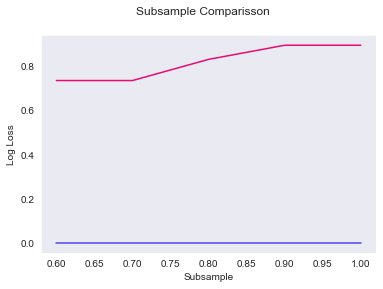

In [15]:
%time
subsamples = list([i/10.0 for i in range(6,10)] + [1])
train_results = []
valid_results = []
for subsample in subsamples:
    model_tune = XGBClassifier(subsample = subsample, eval_metric = 'mlogloss', 
                               max_depth = best_max_depth, min_child_weight = best_min_child_weight,
                               seed = seed, n_jobs = None)
    model_tune.fit(X_train, Y_train)
    train_pred = model_tune.predict(X_train)
    ll_train = log_loss(Y_train, train_pred)
    train_results.append(ll_train)
    valid_pred = model_tune.predict(X_validation)
    ll_valid = log_loss(Y_validation, valid_pred)
    valid_results.append(ll_valid)
    print('%s: %f (train) %f (validation))' % (subsample, ll_train, ll_valid))
    
    # identify best subsample
    if subsample == subsamples[0]:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_subsample = subsample
    elif ll_valid < best_ll_valid:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_subsample = subsample
    elif ll_valid == best_ll_valid:
        if ll_train < best_ll_train:
            best_subsample = subsample
     
    
print('\nNew parameter value for subsample = ' + str(best_subsample))  

fig = plt.figure()
fig.suptitle('Subsample Comparisson')
line1 = plt.plot(subsamples, train_results, label = 'Train Log Loss')
line2 = plt.plot(subsamples, valid_results, label = 'Validation Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('Subsample')
plt.show()

**iv. Col Sample by Tree :** denotes the fraction of columns to be randomly samples for each tree.
- Default = 1

Wall time: 0 ns
0.6: 0.000000 (train) 0.892971 (validation))
0.7: 0.000000 (train) 0.861080 (validation))
0.8: 0.000000 (train) 0.701620 (validation))
0.9: 0.000000 (train) 0.829189 (validation))
1: 0.000000 (train) 0.733513 (validation))

New parameter value for colsample_bytree = 0.8


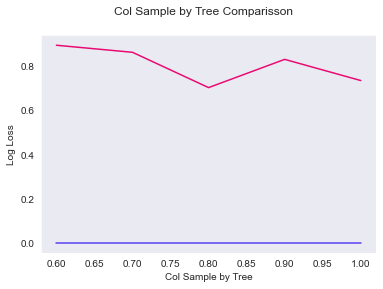

In [16]:
%time
colsample_bytrees = list([i/10.0 for i in range(6,10)] + [1])
train_results = []
valid_results = []
for colsample_bytree in colsample_bytrees:
    model_tune = XGBClassifier(colsample_bytree = colsample_bytree, eval_metric = 'mlogloss', 
                               seed = seed, n_jobs = None, 
                               max_depth = best_max_depth, min_child_weight = best_min_child_weight,
                               subsample = best_subsample)
    model_tune.fit(X_train, Y_train)
    train_pred = model_tune.predict(X_train)
    ll_train = log_loss(Y_train, train_pred)
    train_results.append(ll_train)
    valid_pred = model_tune.predict(X_validation)
    ll_valid = log_loss(Y_validation, valid_pred)
    valid_results.append(ll_valid)
    print('%s: %f (train) %f (validation))' % (colsample_bytree, ll_train, ll_valid))
    
    # identify best colsample_bytree
    if colsample_bytree == colsample_bytrees[0]:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_colsample_bytree = colsample_bytree
    elif ll_valid < best_ll_valid:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_colsample_bytree = colsample_bytree
    elif ll_valid == best_ll_valid:
        if ll_train < best_ll_train:
            best_colsample_bytree = colsample_bytree
            
     
    
print('\nNew parameter value for colsample_bytree = ' + str(best_colsample_bytree))  

fig = plt.figure()
fig.suptitle('Col Sample by Tree Comparisson')
line1 = plt.plot(colsample_bytrees, train_results, label = 'Train Log Loss')
line2 = plt.plot(colsample_bytrees, valid_results, label = 'Validation Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('Col Sample by Tree')
plt.show()

**v. Gamma :** A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative.
- Default = 0

Wall time: 0 ns
0.0: 0.000000 (train) 0.701620 (validation))
0.1: 0.000000 (train) 0.924863 (validation))
0.2: 0.000000 (train) 0.988650 (validation))
0.3: 0.000000 (train) 0.733511 (validation))
0.4: 0.000000 (train) 0.988648 (validation))
1: 0.000000 (train) 0.956757 (validation))

New parameter value for gamma = 0.0


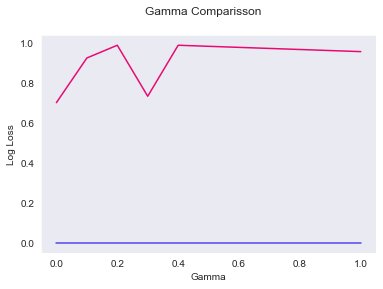

In [17]:
%time
gammas = list([i/10.0 for i in range(0,5)] + [1])
train_results = []
valid_results = []
for gamma in gammas:
    model_tune = XGBClassifier(gamma = gamma, eval_metric = 'mlogloss',
                               seed = seed, n_jobs = None, 
                               max_depth = best_max_depth, min_child_weight = best_min_child_weight,
                               subsample = best_subsample, colsample_bytree = best_colsample_bytree)
    model_tune.fit(X_train, Y_train)
    train_pred = model_tune.predict(X_train)
    ll_train = log_loss(Y_train, train_pred)
    train_results.append(ll_train)
    valid_pred = model_tune.predict(X_validation)
    ll_valid = log_loss(Y_validation, valid_pred)
    valid_results.append(ll_valid)
    print('%s: %f (train) %f (validation))' % (gamma, ll_train, ll_valid))
    
    # identify best gamma
    if gamma == gammas[0]:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_gamma = gamma
    elif ll_valid < best_ll_valid:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_gamma = gamma
    elif ll_valid == best_ll_valid:
        if ll_train < best_ll_train:
            best_gamma = gamma
     
    
print('\nNew parameter value for gamma = ' + str(best_gamma))  

fig = plt.figure()
fig.suptitle('Gamma Comparisson')
line1 = plt.plot(gammas, train_results, label = 'Train Log Loss')
line2 = plt.plot(gammas, valid_results, label = 'Validation Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('Gamma')
plt.show()

**vi. Alpha :** L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
- Default = 0

Wall time: 0 ns
1e-05: 0.000000 (train) 0.701620 (validation))
0.01: 0.000000 (train) 0.892973 (validation))
0.1: 0.000000 (train) 0.956756 (validation))
1: 0.000000 (train) 0.892972 (validation))
100: 2.026543 (train) 2.328111 (validation))

New parameter value for reg_alpha = 1e-05


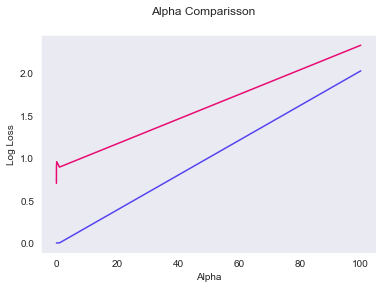

In [18]:
%time
alphas = list([1e-5, 1e-2, 0.1, 1, 100])
train_results = []
valid_results = []
for alpha in alphas:
    model_tune = XGBClassifier(reg_alpha = alpha, eval_metric = 'mlogloss',
                               seed = seed, n_jobs = None, 
                               max_depth = best_max_depth, min_child_weight = best_min_child_weight,
                               subsample = best_subsample, colsample_bytree = best_colsample_bytree,
                               gamma = best_gamma)
    model_tune.fit(X_train, Y_train)
    train_pred = model_tune.predict(X_train)
    ll_train = log_loss(Y_train, train_pred)
    train_results.append(ll_train)
    valid_pred = model_tune.predict(X_validation)
    ll_valid = log_loss(Y_validation, valid_pred)
    valid_results.append(ll_valid)
    print('%s: %f (train) %f (validation))' % (alpha, ll_train, ll_valid))
    
    # identify best reg_alpha
    if alpha == alphas[0]:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_alpha = alpha
    elif ll_valid < best_ll_valid:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_alpha = alpha
    elif ll_valid == best_ll_valid:
        if ll_train < best_ll_train:
            best_alpha = alpha
     
    
print('\nNew parameter value for reg_alpha = ' + str(best_alpha))  

fig = plt.figure()
fig.suptitle('Alpha Comparisson')
line1 = plt.plot(alphas, train_results, label = 'Train Log Loss')
line2 = plt.plot(alphas, valid_results, label = 'Validation Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('Alpha')
plt.show()

**vii. Number of estimators**     

Wall time: 0 ns
1: 1.555818 (train) 2.806502 (validation))
2: 1.148909 (train) 2.009194 (validation))
4: 0.534560 (train) 1.594598 (validation))
8: 0.287225 (train) 1.180001 (validation))
16: 0.079785 (train) 0.988648 (validation))
32: 0.000000 (train) 0.924864 (validation))
64: 0.000000 (train) 0.733512 (validation))
100: 0.000000 (train) 0.701620 (validation))
150: 0.000000 (train) 0.733513 (validation))
200: 0.000000 (train) 0.733513 (validation))

New parameter value for n_estimators = 100


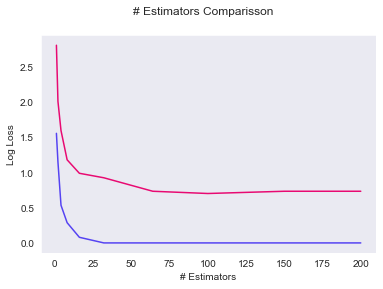

In [19]:
%time
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200]
train_results = []
valid_results = []
for estimator in n_estimators:
    model_tune = XGBClassifier(n_estimators = estimator, eval_metric = 'mlogloss',
                               seed = seed, n_jobs = None, 
                               max_depth = best_max_depth, min_child_weight = best_min_child_weight,
                               subsample = best_subsample, colsample_bytree = best_colsample_bytree,
                               gamma = best_gamma, reg_alpha = best_alpha)
    model_tune.fit(X_train, Y_train)
    train_pred = model_tune.predict(X_train)
    ll_train = log_loss(Y_train, train_pred)
    train_results.append(ll_train)
    valid_pred = model_tune.predict(X_validation)
    ll_valid = log_loss(Y_validation, valid_pred)
    valid_results.append(ll_valid)
    print('%s: %f (train) %f (validation))' % (estimator, ll_train, ll_valid))
    
    # identify best n_estimators
    if estimator == n_estimators[0]:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_estimator = estimator
    elif ll_valid < best_ll_valid:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_estimator = estimator
    elif ll_valid == best_ll_valid:
        if ll_train < best_ll_train:
            best_estimator = estimator  


print('\nNew parameter value for n_estimators = ' + str(best_estimator))  

fig = plt.figure()
fig.suptitle('# Estimators Comparisson')
line1 = plt.plot(n_estimators, train_results, label = 'Train Log Loss')
line2 = plt.plot(n_estimators, valid_results, label = 'Validation Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('# Estimators')
plt.show()

**viii. Learning rate:** makes the model more robust by shrinking the weights on each step
- Default = 0.3

Wall time: 0 ns
1: 0.000000 (train) 0.988649 (validation))
0.5: 0.000000 (train) 0.924865 (validation))
0.25: 0.000000 (train) 0.892972 (validation))
0.1: 0.000000 (train) 0.988647 (validation))
0.05: 0.055849 (train) 1.020540 (validation))
0.01: 0.382967 (train) 1.052432 (validation))

New parameter value for learning_rate = 0.25


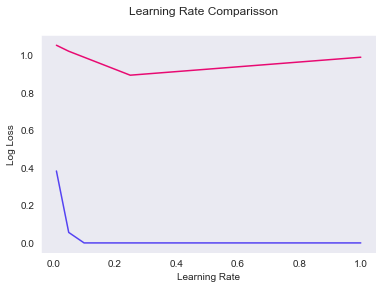

In [20]:
%time
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
valid_results = []
for eta in learning_rates:
    model_tune = XGBClassifier(learning_rate = eta, eval_metric = 'mlogloss',
                               seed = seed, n_jobs = None,
                               max_depth = best_max_depth, min_child_weight = best_min_child_weight,
                               subsample = best_subsample, colsample_bytree = best_colsample_bytree,
                               gamma = best_gamma, reg_alpha = best_alpha, n_estimators = best_estimator)
    model_tune.fit(X_train, Y_train)
    train_pred = model_tune.predict(X_train)
    ll_train = log_loss(Y_train, train_pred)
    train_results.append(ll_train)
    valid_pred = model_tune.predict(X_validation)
    ll_valid = log_loss(Y_validation, valid_pred)
    valid_results.append(ll_valid)
    print('%s: %f (train) %f (validation))' % (eta, ll_train, ll_valid))
    
    # identify best learning_rate
    if eta == learning_rates[0]:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_eta = eta
    elif ll_valid < best_ll_valid:
        best_ll_valid = ll_valid
        best_ll_train = ll_train
        best_eta = eta
    elif ll_valid == best_ll_valid:
        if ll_train < best_ll_train:
            best_eta = eta
     
    
print('\nNew parameter value for learning_rate = ' + str(best_eta))  

fig = plt.figure()
fig.suptitle('Learning Rate Comparisson')
line1 = plt.plot(learning_rates, train_results, label = 'Train Log Loss')
line2 = plt.plot(learning_rates, valid_results, label = 'Validation Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('Learning Rate')
plt.show()

<a id="id_5"></a>
## 5. Build Model & Evaluate on Validation
#### 5a) Build Model

In [21]:
model = XGBClassifier(eval_metric = 'mlogloss', seed = seed, n_jobs = None,
                      max_depth = best_max_depth, min_child_weight = best_min_child_weight,
                      subsample = best_subsample, colsample_bytree = best_colsample_bytree,
                      gamma = best_gamma, reg_alpha = best_alpha,
                      n_estimators = best_estimator, learning_rate = best_eta)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='mlogloss', gamma=0.0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=24, reg_alpha=1e-05, reg_lambda=1,
              scale_pos_weight=1, seed=24, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### 5b) Evaluate Model on validation set

In [22]:
# make predictions on validation set
predictions = model.predict(X_validation)
probs = model.predict_proba(X_validation)
probs_1 = []
for i in range(len(probs)):
    probs_1.append(probs[i][1])
    
print('Accuracy = ' + str(accuracy_score(Y_validation, predictions)))
print('Log Loss = ' + str(log_loss(Y_validation, probs)))
print('ROC-AUC = ' + str(roc_auc_score(Y_validation, probs_1)))
print('Gini = ' + str(2 * roc_auc_score(Y_validation, probs_1) - 1))
print(classification_report(Y_validation, predictions))
display(pd.crosstab(Y_validation, predictions, rownames = ['Actual'], colnames = ['Predicted'], margins = True))

fpr, tpr, thresholds = roc_curve(Y_validation, probs_1)
roc_auc = auc(fpr, tpr)

df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
cf.set_config_file(dimensions = (800, 800), margin = (70, 70, 70, 70))
CI = [{'x0' : 0, 'y0' : 0, 'x1' : 1, 'y1' : 1, 'color' : 'black'}]
df.iplot(x = 'fpr', y = 'tpr', vline = CI, title = 'ROC Curve',
         xTitle = 'False Positive Rate', yTitle = 'True Positive Rate',
         colors = rgb_palette[0])

Accuracy = 0.974145891043398
Log Loss = 0.06858411589460757
ROC-AUC = 0.9970082171569866
Gini = 0.9940164343139732
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       562
         1.0       0.99      0.95      0.97       521

    accuracy                           0.97      1083
   macro avg       0.98      0.97      0.97      1083
weighted avg       0.97      0.97      0.97      1083



Predicted,0.0,1.0,All
Actual,,,
0.0,559,3,562
1.0,25,496,521
All,584,499,1083


#### 5c) Save Model

In [23]:
with open(path + 'model_mum_os.pkl', 'wb') as file:
    pickle.dump(model, file)

<a id="id_6"></a>
## 6. Feature Importance
#### 6a) XGBoost feature importance
The plot indicates which features have a large impact on the Model scores, however it doesn't explain the direction of this impact. So we know that whether the title is unrated or a drama is imprtant but we don't know if mum is more or less likely to watch the title if it is rated or a drama.

In [24]:
%%time
feature_names = list(os_train_df.columns)[1:]

feature_importance = pd.DataFrame(feature_names, columns = ['Feature'])
feature_importance['Importance'] = model.feature_importances_

feature_importance.sort_values('Importance', inplace = True)
feature_importance.set_index('Feature', inplace = True)

cf.set_config_file(dimensions = (1800, 1800), margin = (50, 50, 50, 50))
feature_importance.iplot(kind = 'barh', title = 'Feature Importance (%)',
                         colors = rgb_palette[0],
                         filename = 'cufflinks/barh')


Wall time: 1.12 s


#### 6b) Shapely Plot
Here we learn more about the direction of the feature importance. We can see that the Model assumes that mum is less likely to watch a title if it is:
- a movie
- not rated adult or teen
- not a mystery, drama or romance
- a comedy
- has a high hidden gem score
- has received few awards
- has few IMDb votes

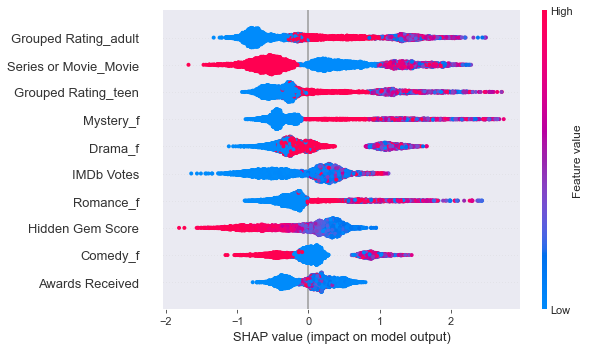

Wall time: 1.65 s


In [25]:
%%time
shap_values = shap.TreeExplainer(model).shap_values(X_train) 
shap.summary_plot(shap_values, X_train, feature_names = feature_names,
                  max_display = 10)

[back to top](#id_0)